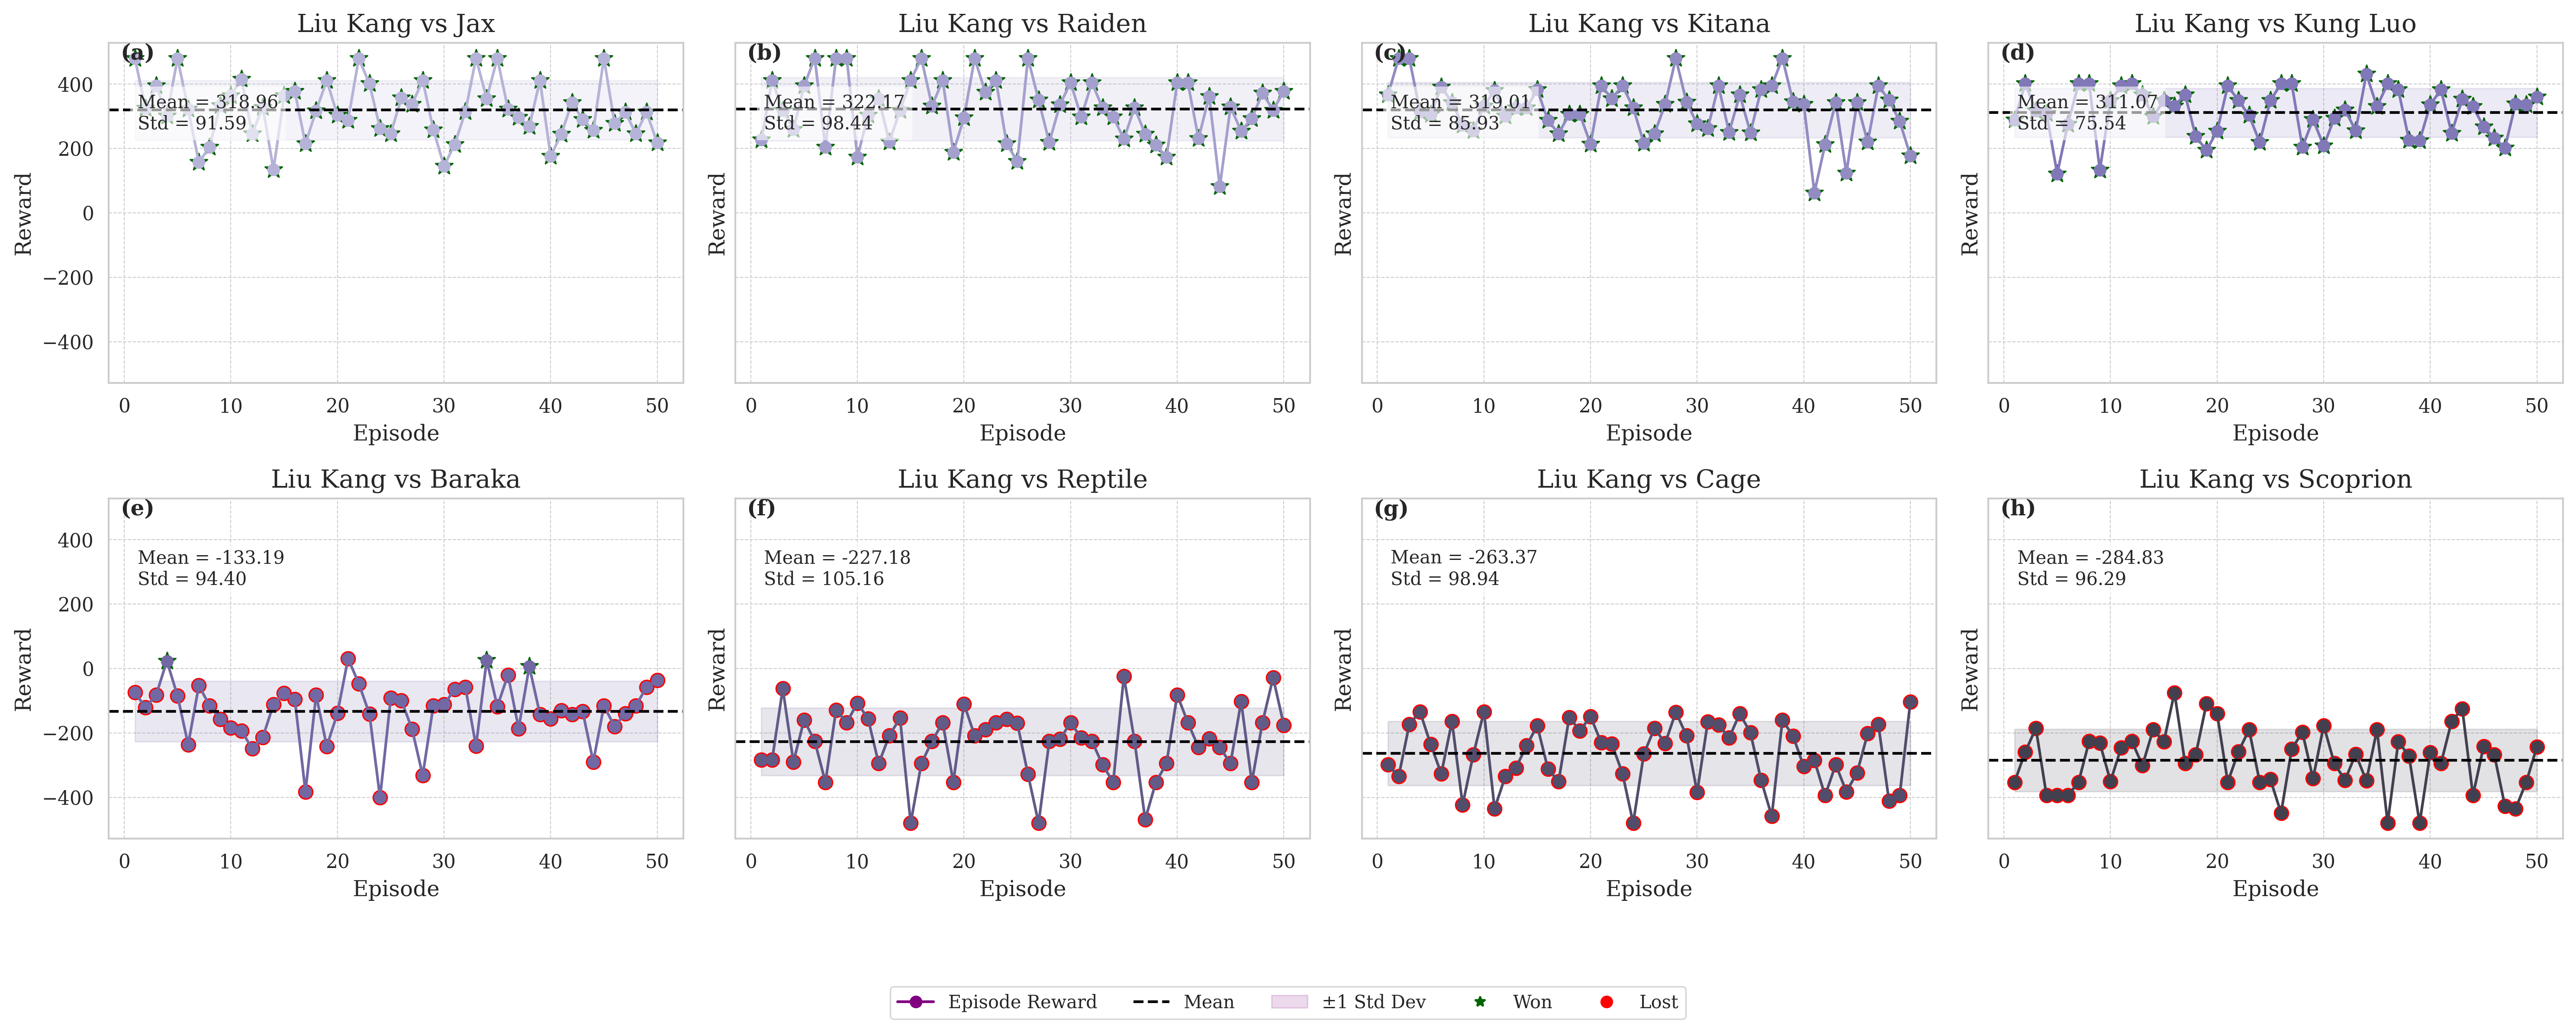

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set an academic style
sns.set_context("paper", font_scale=1.2)
sns.set_style("whitegrid")
plt.rc('font', family='serif')
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'legend.fontsize': 10,
    'figure.dpi': 300,
})

results_folder = "evaluation_results"

# Gather CSV files
csv_files = [
    f for f in os.listdir(results_folder)
    if f.startswith("evaluation_results_") and f.endswith(".csv")
]
n_states = len(csv_files)

# dictionary to map file names (extracted states) to descriptive titles
title_map = {
    "VeryEasy.LiuKang-01": "Liu Kang vs Jax",
    "VeryEasy.LiuKang-02": "Liu Kang vs Raiden",
    "VeryEasy.LiuKang-03": "Liu Kang vs Kitana",
    "VeryEasy.LiuKang-04": "Liu Kang vs Kung Luo",
    "VeryEasy.LiuKang-05": "Liu Kang vs Baraka",
    "VeryEasy.LiuKang-06": "Liu Kang vs Reptile",
    "VeryEasy.LiuKang-07": "Liu Kang vs Cage",
    "VeryEasy.LiuKang-08": "Liu Kang vs Scoprion",
    # etc...
}

# Create subplots
n_cols = 4
n_rows = int(np.ceil(n_states / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4), sharey=True)
axes = axes.flatten()

# Generate a purple color palette for all subplots
palette = sns.color_palette("Purples_d", n_colors=n_states)

# --- 1) Create custom legend handles ---
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

line_handle = mlines.Line2D([], [], color='purple', marker='o', label='Episode Reward')
mean_handle = mlines.Line2D([], [], color='black', linestyle='--', label='Mean')
std_patch = mpatches.Patch(color='purple', alpha=0.15, label='±1 Std Dev')
won_handle = mlines.Line2D([], [], color='darkgreen', marker='*', linestyle='None', label='Won')
lost_handle = mlines.Line2D([], [], color='red', marker='o', linestyle='None', label='Lost')

custom_legend_handles = [line_handle, mean_handle, std_patch, won_handle, lost_handle]

for i, filename in enumerate(csv_files):
    # Extract the state name (remove prefix/suffix)
    state = filename.replace("evaluation_results_", "").replace(".csv", "")

    # Read the CSV
    file_path = os.path.join(results_folder, filename)
    df = pd.read_csv(file_path)

    # Filter out non-numeric episodes
    df = df[pd.to_numeric(df["episode"], errors="coerce").notnull()]
    df["episode"] = df["episode"].astype(int)

    avg_reward = df["reward"].mean()
    std_reward = df["reward"].std()

    ax = axes[i]
    episodes = df["episode"]
    rewards = df["reward"]

    # Pick a unique shade of purple for each subplot
    color = palette[i]

    # Plot the episode rewards
    ax.plot(episodes, rewards, marker='o', linestyle='-', color=color)

    # Plot average line
    ax.axhline(avg_reward, color='black', linestyle='--', linewidth=1.5)

    # Fill +/- std
    ax.fill_between(
        episodes,
        avg_reward - std_reward,
        avg_reward + std_reward,
        color=color, alpha=0.15
    )

    # Mark won vs lost
    won_df = df[df["won"] == True]
    lost_df = df[df["won"] == False]
    ax.scatter(won_df["episode"], won_df["reward"], color='darkgreen', marker='*', s=100)
    ax.scatter(lost_df["episode"], lost_df["reward"], color='red', marker='o', s=60)

    # Determine subplot title from the mapping
    subplot_title = title_map.get(state, state)
    ax.set_title(subplot_title)

    ax.set_xlabel("Episode")
    ax.set_ylabel("Reward")
    ax.set_xticks(episodes)

    ax.set_xticks([0, 10, 20, 30, 40, 50])
    
    ax.grid(True, linestyle='--', linewidth=0.5)

    # Annotate with numeric mean/std
    ax.text(
        0.05, 0.85,
        f"Mean = {avg_reward:.2f}\nStd = {std_reward:.2f}",
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

    # Label subplots (a), (b), (c), ...
    ax.text(0.02, 0.95, f"({chr(97 + i)})", transform=ax.transAxes,
            fontsize=12, fontweight='bold')

# Remove any unused subplots if n_states < n_rows*n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Single, consolidated legend at bottom
fig.legend(
    handles=custom_legend_handles,
    loc='lower center',
    ncol=5,
    bbox_to_anchor=(0.5, -0.05)
)

# Adjust layout so nothing overlaps
plt.tight_layout(rect=[0, 0.05, 1, 0.95])

# Save as PDF
plt.savefig("outputs/combined_evaluation_plots.pdf", format="pdf", bbox_inches="tight")
plt.show()
